# Graphene Ring

#### Import the different "Package"

In [2]:


#%run matplotlib_setup.ipy
from matplotlib import pyplot as plt
import numpy as np
import kwant
import math
from math import atan2, pi, sqrt, cos, sin
from cmath import exp
from types import SimpleNamespace


#### Fundamental constant 

In [11]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
a = 1 # new constant

#### Definition of the graphene function with some parameters

* R_ext is the external radius 
* W is the width of one ring arm
* W_L is the width of the lead
* L_L is the length of the lead starting from the outer circle


In [12]:

def potential (site,params):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    
    """
    x, y = site.pos
    
    if shape == 'square':
        in_shape = abs(x) < l_pot and y+W/2 < w_pot
    
    elif shape == 'circle':
        in_shape = x**2 + y**2 < R_ext**2
        
    else:
        in_shape = False
    
    if in_shape:
        return 4*(t + Vg)
    else:
        return 4*t

In [25]:
def position_arm_1(pos, theta_1, theta_2):
    x, y = pos
    r = sqrt(x**2 + y**2)
    theta = atan2(y,x)
    if theta_1 <theta< theta_2:
        return True
    else:
        return False

In [9]:
print(atan2(1,-1)/pi * 180 )
print(sin(-135*pi/180))

135.0
-0.7071067811865476


In [13]:
def make_system(a=1.0,t=1.0,R_ext=350,W=150,W_L=150,L_L=100,magn_activated=0, pot=0.1):
    
    graphene = kwant.lattice.honeycomb(a,norbs=1)
    a_lat, b_lat = graphene.sublattices
    sys = kwant.Builder()
 
    # definition geometry
    def circle(pos): return (pos[0]**2 + pos[1]**2 <R_ext**2  and pos[0]**2 + pos[1]**2 >(R_ext-W)**2) \
                            or ((R_ext-W/2)<pos[0]<(R_ext+L_L )
                            and abs(pos[1])<W_L/2) \
                            or (-(R_ext-W/2)>pos[0]>-(R_ext+L_L) 
                            and abs(pos[1])<W_L/2) 
    # definition hopping for magentic field        
    def hopping(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        return -t * exp(-0.5j*phi/(h/e)/pi*(xi-xj)*(yi+yj))

    sys[graphene.shape(circle, (R_ext-W/2,0))] = 0 # onsite energy is zero (later a potential will be applied)
    hoppings = (((0, 0), a_lat, b_lat), ((0, 1), a_lat, b_lat), ((-1, 1), a_lat, b_lat))
    
     
    if magn_activated==0:
         sys[[kwant.builder.HoppingKind(*hoppingg) for hoppingg in hoppings]] = -t
    
    elif magn_activated==1:
        sys[graphene.neighbors()] = hopping
        
    else:
        print('Wrong input parameter for the magnetic field')
   
    
    
    
    
    
    sym=kwant.TranslationalSymmetry(graphene.vec((1,0)))
    def lead_shape(R): return abs(R[1]) < W_L/2
    
    Hlead =kwant.Builder(sym)
    Hlead[graphene.shape(lead_shape,(0,0) )]=0
    
    
    
    
    if magn_activated==0:
         Hlead[graphene.neighbors()]=-t
    
    elif magn_activated==1:
        Hlead[graphene.neighbors()] = hopping
        
    else:
        print('Wrong input parameter for the magnetic field')
   
    
    
    sys.attach_lead(Hlead)
    sys.attach_lead(Hlead.reversed())
    
    
    return sys

In [29]:
params = SimpleNamespace(phi=phi, Vg=Vg, l_pot=l_pot, w_pot=w_pot, R_ext=R_ext, shape=shape)

NameError: name 'phi' is not defined

In [30]:
vals=[onsite(sys.sites[n], params) for n in range(sys.graph.num_nodes)]
kwant.plotter.map(sys, vals)

NameError: name 'sys' is not defined

#### Creation of the physical graphene ring

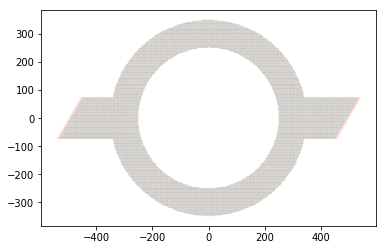

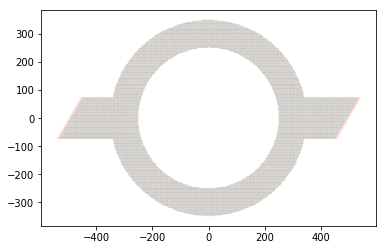

In [13]:
scaling_fact=20
#n2D=1.2e16
#scaling_fact=25
a0=0.246
a=a0*scaling_fact
t0=2.8
t=t0/scaling_fact
R_ext=350
W=100
W_L=150
L_L=100
pot = 0.1
magn_activated=0
H=make_system(a,t,R_ext,W,W_L,L_L,magn_activated, pot)
kwant.plot(H)

## Analysis of the transmission

In [10]:
scaling_fact=15
#n2D=1.2e16
#scaling_fact=25
a0=0.246
a=a0*scaling_fact
t0=2.8
t=t0/scaling_fact
R_ext=350
W=200
W_L=150
L_L=100
magn_activated=0

In [11]:
%matplotlib inline
H=make_system(a,t,R_ext,W,W_L,L_L,magn_activated)

Hf=H.finalized()
#max_E=0.1
#n=10
#E_vect=np.zeros(n)
#T_vect=np.zeros(n)
#init_val=0.000001
#incr=(max_E-init_val)/(n-1)

#Results=open("Ring_var_E_fixed_W_R.txt",'w') # Warning: reset every time the results of the .txt file
#for i in range(0,n):  
#  E_vect[i]=init_val
#  smatrix = kwant.smatrix(Hf, energy = init_val)
#  T_vect[i]=smatrix.transmission(1, 0)
#  init_val=init_val+incr
#  Results.write(str(E_vect[i])+"   "+str(T_vect[i])+"   "+"\n")
#  print(E_vect[i])
#  print(i)
#Results.close()
#plt.plot(E_vect,T_vect)
#plt.ylabel('transmission T')'
#plt.xlabel('Energy E')
#plt.show()


E = np.linspace(-0.13,0.13,500)
#print(E)
T2 = []
for x in E:
    smatrix = kwant.smatrix(Hf, energy = x)
    T = smatrix.transmission(1,0)
    T2.append(T)
    #print(x)
    
#print(T2)    
plt.plot(E,T2)    

UserCodeError: Error occurred in user-supplied value function "potential".
See the upper part of the above backtrace for more information.

## magnetic field 


AB oscillation have a period given by 
Detlta_B=h_bar/(e*R_mean^2)


In [27]:
scaling_fact=20
#n2D=1.2e16
#scaling_fact=25
a0=0.246
a=a0*scaling_fact
#e=1.602e-19
t0=2.8
t=t0/scaling_fact
R_ext=350
W=100
W_L=150
L_L=100
magn_activated=1 # we activate the magnetic field here !



In [28]:



H=make_system(a,t,R_ext,W,W_L,L_L,magn_activated)

H_mf=H.finalized()

#### For a realistic value of phi ####
#B = 0.05 # (Tesla) value of the magnetic field (well, the magnetic flux density for the purists among you)

#phi = B * a**2 *sqrt(3)/2)/scaling_fact**2 # with 'a' being the scale value 

E=0.1
N = 200 # number of magnetic field values
Bmax = 0.05 # higher magnetic field
Bs = np.linspace(-Bmax, Bmax, N) # vector of the magnetic fields

G = np.zeros([N,1])

for i,B in enumerate(Bs):
    phi = B * a**2 *sqrt(3)/2 * (1e-18)
    smatrix = kwant.smatrix(H_mf, energy = E,args=[phi] ) # transmission matrix (here this)
    T = smatrix.transmission(1, 0) # transmission value obtained from the left lead towards the right lead
    G[i] = T
    
plt.plot(Bs,G)

plt.xlabel('Magnetic field (T)')
plt.ylabel('Transmission (2e²/h)')

plt.show()
#data = []
#phis = np.linspace(0,1.,10)
#for phi in phis:
#    smatrix = kwant.smatrix(Hf, 3.3,args=[phi])
#    data.append(smatrix.transmission(1, 0))
#pyplot.plot(phis, data,'o');
#pyplot.xlabel('$\phi = BS/(h/e)$')
#pyplot.ylabel('g in unit of $(2e^2/h)$');
#pyplot.title('Aharonov-Effect')





UserCodeError: Error occurred in user-supplied value function "potential".
See the upper part of the above backtrace for more information.